# Debug Notebook for Photon Model Capture

## Initialize the Notebook

The following cell allows external notebooks to be imported as modules.

In [1]:
import io, os, sys, types

from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

    
sys.meta_path.append(NotebookFinder())


print ('Complete')

Complete


### Import Notebooks

This cell imports all required notebooks.

In [2]:
from MasterFunctions_Capture import *

print ()
print ('All notebooks imported')

importing Jupyter notebook from MasterFunctions_Capture.ipynb
importing Jupyter notebook from MasterFunctions_ModelData.ipynb
------ MasterFunctions_ModelData Imported ------
------ MasterFunctions_Capture Imported ------

All notebooks imported


## Sanity Checks

The following section provides sanity checks to ensure that python is reading in the PREM file correctly.

### Core-Mantle Separator

This cell determines the index at which the core-mantle separator is specified.

In [ ]:
print ('Core-Mantle Separator radius: {0} cm'.format(RCrit))

for i in range(0,len(radiusList)):
    if radiusList[i] == RCrit: 
        print ('Core-Mantle separator index : {0}'.format(i))
        break
        
print ('Complete')

### Shell Thickness Check

The array "radiusList" stores the list of radii values from the PREM500 file in units of centimeters, not meters as the raw data has. The conversion is found in the MasterFunctions_ModelData file.

A note about the zero values: 

Let R = radiusList

radius = [ R[0], R[1], ... , R[490] ]

s = [ 0, R[0], R[1], ..., r[489] ]

They all have length of 491

We define the shell thickness as follows:

\begin{equation}
\Delta R = R[i] - s[i]
\end{equation}

Checks out with Flips notebook: 7/8/17

In [ ]:
xRange = range(0,len(radiusList))
plt.plot(xRange,deltaRList,'.')
plt.suptitle('Shell Thickness vs Radius Index')
plt.xlabel('Radius Index')
plt.ylabel('Shell Thickness $[cm]$')
plt.grid()

plt.axis([0,491,1.275e6,1.289e6])

print ('Complete')

### Shell Density Check

In this cell, we plot the density vs radius.

In [ ]:
plt.plot(xRange,densityList,'.')
plt.xlabel('Radius Index')
plt.ylabel('Density $[g/cm^3]$')
plt.suptitle('Density vs Radius Index')
plt.grid()

print ('Complete')

### Enclosed Mass Check

This cell provides a double check that the enclosed mass from PREM500 matches the mass of earth.

Check confirmed: 7/8/17

In [ ]:
mass = 0.
for i in xRange:
    mass = mass + 4. * np.pi * radiusList[i]**2 * densityList[i] * deltaRList[i]
print ('Enclosed Mass = {0} g'.format(mass))
print ('Complete')

### Shell Mass Check

We create a vector named "shellMassList" which returns the mass of the shell at index "i."

Check confirmed: 7/8/17

In [ ]:
plt.plot(xRange,shellMassList,'.')
plt.suptitle('Shell Mass vs. Radius Index')
plt.xlabel('Radius Index')
plt.ylabel('Enclosed Mass $[g]$')
plt.grid()

# print (shellMassList[0:4])
# print (shellMassList[-4:-1])
# print (shellMassList)
print ('Complete')

### Enclosed Mass at Each Radius

In this cell, we plot the array "enclosedMassList," which stores the mass enclosed up to index "i."

We will later interpolate this into a function.

Check confirmed: 7/8/17

In [ ]:
plt.plot(xRange,enclosedMassList)
plt.suptitle('Enclosed Mass vs Radius Index')
plt.xlabel('Radius Index')
plt.ylabel('Enclosed Mass $[g]$')
plt.grid()

# print (enclosedMassList[0:4])
# print (enclosedMassList[-4:])

print ('Complete')

### Escape Velocity: $v_{\oplus}(r)$

The escape velocity in natural units is given by:
\begin{equation} 
V_{esc}^2 = \frac{2G}{c^2} \left[ \int_{0}^{r} \frac{M_{enc}(s)}{s^2} \, ds + \frac{M_{total}}{R_{earth}} \right]
\end{equation}

However, we are given discretized data, so we convert the integral into a discrete sum over the radius of earth:
\begin{equation}
V_{esc}^2 = \frac{2G}{c^2} \left[ \sum_i \frac{M_{enc}(s)}{s^2} \, \Delta R + 
\frac{M_{total}}{R_{earth}} \right] 
\end{equation}

where $M_{enc}(s)$ is the mass enclosed at radius $s$ and $\Delta R$ is the change in radius going from the previous radius  to the current radius $\Delta R =$ r[i] - r[i-1].

The accumulate function acts just like the "Accumulate" in mathematica. It adds up "Summand" starting at "index" and sums over the length of the radius index.


Escape Velocities are stored in the list: escVel2List

Note: The value from escVel2List[1] is assigned to the zero-index slot of escVel2List to work around a 'nan' escape velocity at r=0.

Check confirmed with EarthChecker_v2: 7/8/17

In [ ]:
# print (escVel2List[0:4])
# print (escVel2List[-4:])
        
plt.plot(radiusList, escVel2List)
plt.xlabel('Radius $[cm]$')
plt.ylabel('Squared Escape Velocity')
plt.suptitle('Squared Escape Velocity vs. Radius')
plt.grid()
plt.show()

print ('Complete')

### Number Densities

The number density $n_N$ for element $"N"$ is given by:
\begin{equation}
n_N(r) = f_N(r) \frac{\rho_{\oplus}(r)}{m_N}
\end{equation}
where $f(N)$ is the mass fraction of element "N" given by Table 1, and $\rho_{\oplus}$ is the density of earth. We calculate the number density for each element found in the earth at each radius of earth specified by $\text{radiusList}$ and store the result in an array named $\text{numDensityList}$.

In this cell, we plot the number densities for two elements, Iron and Silicon

In [ ]:
fig0 = plt.figure()
ax0 = fig0.add_subplot(111)
set1, = plt.plot(range1, numDensityList('Fe56'),'.')
set2, = plt.plot(range1, numDensityList('Si28'),'.')
plt.legend([set1,set2],['Iron','Silicon'])

plt.suptitle('Number Densities')
plt.xlabel('Radius Index')
plt.ylabel(r'Number Density $[cm^{-3}]$')
plt.grid()
plt.show()

# print (amu2GeV(atomicNumbers['Fe56']))
# print (numDensityList('Fe56'))

print ('Complete')

### Escape Velocity Interpolation Check

In this cell, we check the inerpolation of the escape velocity by plotting the first 40 points of "escVel2List" and the resulting interpolation.

In [ ]:
alist = range(0,40)
tempEsc = []
for i in alist:
    tempEsc.append(escVel2List[i])
    
plt.plot(alist,tempEsc,'.',alist,escVel2Interp(radiusList[alist]),'-')
plt.xlabel('Radius Index')
plt.ylabel('Squared Escape Velocity')
plt.suptitle('Escape Velocity vs Radius Index')
plt.legend(['List Values','Interpolation'])
plt.grid()
print ('Complete')

-----------

# Capture Rate

### General Motivation

Our final goal is to calculate:

\begin{equation}
C_{cap} = \sum_N C^N_{cap} = \sum_N n_X \, c^N_{cap,red}
\end{equation}

Where the single-element capture rate $c^N_{cap,red}$ is the product of three integrals over the volume of earth $d^3r$, the incident DM velocity $d^3u$, and the dark matter recoil energy $E_R$ given by:. 

\begin{equation}
c^N_{cap,red} = 
\int_{0}^{R_{\oplus}}dr \, 4 \pi r^2 n_N(r) 
\int_{0}^{V_{gal}} du \, 4 \pi u^2 f(u) \frac{u^2 + v_{\oplus}^2(r)}{u}
\int_{E_{min}}^{E_{max}} \, dE_R \frac{d\sigma_N}{dE_R} \Theta (\Delta E)
\end{equation}

where finally the differential cross section as a function of recoil energy $ \frac{d\sigma_N}{dE_R} $ is given by:

\begin{equation} 
\frac{d\sigma_N}{dE_R} \approx 
8 \pi \epsilon^2 \alpha_X \alpha Z_N^2 \frac{m_N}{(u^2 + v_{\oplus})^2(2m_NE_R + m_{A}^2)^2} \left | F_N \right| ^2
\end{equation}


We can see that in calculating the capture rate, the $m_A$ and $\varepsilon$ dependence is carried only in the differential cross section. Further, in the small $E_R$ limit, we have shown that the differential capture rate can be written as:

\begin{align}
\frac{d\sigma_N}{d\xi} &\approx
8 \pi \alpha_X \alpha Z_N^2 \, \frac{\varepsilon^2}{m_A^4} \frac{m_N}{(u^2 + v^2_{\oplus})} \left| F_N \right|^2  \\
&\approx \frac{d\sigma'_N}{d\xi_R} \frac{\varepsilon^2}{m_A^4}
\end{align}

where $\frac{d\sigma'_N}{d\xi_R}$ is now explicitly independent of $m_A$ and $\varepsilon$. This leads us to construct a quantity $\kappa_0$ which only depends on $m_X$, $\alpha$, and $\alpha_X$, pulling the $\varepsilon$ and $m_A$ dependence out of the integrals.

We define $\kappa_0$ as follows:
\begin{equation}
\kappa_0(m_X, \alpha, \alpha_X) \equiv 
\int_{0}^{R_{\oplus}}dr \, 4 \pi r^2 n_N(r) 
\int_{0}^{V_{gal}/c} du \, 4 \pi u^2 f(u) \frac{u^2 + v_{\oplus}^2(r)}{u}
\int_{\xi_{min}}^{\xi_{max}} \, dE_R \frac{d\sigma_N}{d\xi} \Theta (\Delta \xi)
\end{equation}

so that the single-element capture rate can be written as:
\begin{equation}
c^N_{cap,red} = \frac{\varepsilon^2}{m_A^4}\kappa_0^N
\end{equation}


### A Note on Testing Functions

The following sections test the full capture calculation and the small recoil energy approximation simulatneously. All functions resulting from the small recoil energy approximation end with "Kappa0."

For example the function "crossSection" is the full cross section while the function "crossSectionkappa0" is the cross section function used only in the calculation of $\kappa_0$.

By construction, we expect 

\begin{equation}
C_{Cap} \equiv \frac{\varepsilon^2}{m_A^4} \sum_N n_X \kappa^N_0
\end{equation}

### A Note on Computational Efficiency

The motivation for the following calculations is to reduce the actual computation as much as possible by multiplying by all constant factors at the end of the calculation.

Factors that are pulled out of calculations will be acounted for in a running total for the length of this section under the heading:

##### Factors Removed

## Function Tests



For the following tests, we define the following values as reference points:

$m_X = 1000$ GeV

$m_A = 1$ GeV

$\varepsilon = 10^{-8}$

$\alpha = \frac{1}{137}$

$\alpha_X = \alpha_{th} = 0.035$

And where these are needed, we set:

Element = "Fe56"

$E_R = 10^{-10}$ GeV

index = 100 $\rightarrow$ r = 129849400 cm


In [3]:
elementTest = 'Fe56'
m_XTest = 1000.
m_ATest = 1.
epsilonTest = 10**-8
alphaTest = 1./137
alpha_XTest = 0.035
E_RTest = 10**-9
indexTest = 100

print ('Complete')

Complete


### Helm Form Factor: $|F_N(E_R)|^2$

The Helm Form Factor is given by:
$$ \left| F_N(E_R) \right| ^2 = e^{[-E_R/E_N]} $$ (see eqn (10) of arXiv: 1509.07525v2)

where $E_N \equiv \frac{0.114 }{ A_{N}^{5/3}} \space GeV$ is the characteristic energy of a nucleus with atomic number $A_N$

This factor accounts for the effective size of a target nucleus in a DM - nucleus scatter when an incoming DM particle scatters of a nucleus inside the earth.

In [ ]:
# testElement = 'O16'
energyRange = np.linspace(0, 5e-3, 200)
energyVect = []
for E in energyRange:
    energyVect.append(formFactor2(elementTest, E))
    
fig = plt.figure()
plt.plot((energyRange),(energyVect))
plt.xlabel('Recoil Energy $[GeV]$')
plt.ylabel(r'$\log(F_N^2)$')
plt.suptitle('Form Factor vs. Recoil Energy')
plt.title('{0}'.format(elementTest), loc='right')
plt.grid()
              
print ('Form Factor for {0}: {1}'.format(elementTest, formFactor2(elementTest,E_RTest)))
    
print ('Complete')

### Cross Section: $ \frac{d\sigma _N}{dE_R} $

The following cell defines the cross section integrand as:
\begin{equation}
\text{photonCrossSection}  = \frac{m_N}{(2m_N E_R + m_{A} ^2)^2} \left| F_N \right|^2
\end{equation}

and the cross section used in the $\kappa_0$ calculation as:
\begin{equation}
\text{photonCrossSectionKappa0} = \left| F_N \right| ^2 
\end{equation}

where $[\text{photonCrossSection}] = \frac{1}{GeV^3}$ and $[\text{photonCrossSectionKappa0} ]$ is dimensionless.

##### Factors Removed (crossSection):  $8\pi \alpha_X \alpha \epsilon^2 m_N Z_N^2$
##### Factors Removed (crossSectionKappa0): $8\pi \alpha_X \alpha \epsilon^2 \frac{m_N m_X^3}{m_A^4} Z_N^2$

In [ ]:
test1 = photonCrossSection(elementTest, m_ATest, E_RTest)
test2 = photonCrossSectionKappa0(elementTest, E_RTest)

print ('Calculation  : {0}'.format(test1))
print ('Kappa0Calc   : {0}'.format(test2))

print ('Complete')

### Dark Matter Velocity Distribution

#### Asymptotic Dark Matter Velocity Distribution

In the following cell we calculate the normalization constant $N_0$ for the incident dark matter velocity distribution:

\begin{equation} 
\frac{1}{N_0} = \int_{0}^{V_{gal}} f(u) \ du = \text{tempA} 
\end{equation}
where $u$ is a naturalized velocity and $f(u)$ is the incident DM velocity distribution which we take to be Maxwell-Boltzmann in shape:

\begin{equation}
\text{DMVelDist} = f(u) =  N_0 \left[ exp \left ( 
\frac{v^2_{gal}-u^2}{ku^2_0}\right) -1 \right] ^k
\Theta(v_{gal} - u)
\end{equation}

Typical values for $v_{gal}$ (km/s), $u_0$ (km/s), and $k$ respectively lie between:

\begin{equation}
220<u_0<270 \ \ \ \ \ \ \ \ 450<v_{gal}<650 \ \ \ \ \ \ \ \ 1.5<k<3.5 
\end{equation}

For computations, we take $u_0 = 245\times 10^6$ cm/s, $v_{gal} = 550\times10^6$ cm/s and $k = 2.5$


#### Earth-frame Dark Matter Velocity Distribution

The modified distribution $ f_{\oplus}$ is the annular and angular averaged dark matter distribution in the rest frame of Earth given by:

\begin{align}
\text{ModDMVelDist} &= f_{\oplus}(u) = \\ \nonumber
&\frac{1}{4} \int_{-1}^{1}\int_{-1}^{1} d\cos\theta \, d\cos\phi \
   f \left[ \left( u^2 + (V_{\odot} + V_{\oplus}\cos\phi)^2 + 2u(V_{\odot} + V_{\oplus} \cos\phi) \cos\theta \right) ^{1/2} \right]
  \end{align}
  

#### Normalization Check

This cell serves to give a sanity check on the normalization of the asymptotic distribution

In [12]:
test1 = Normalization()
test2 = integrate.quad(NormalizationChecker,0, V_gal)

print ('Normalization N_0    : {0}'.format(test1))
print ('Normalization Check  : {0}'.format(test2))

Normalization N_0    : 4347914.767372669
Normalization Check  : (1.0000000001088114, 6.433480284819202e-09)


#### Dark Matter Velocity Plots

The following cell plots the galactic dark matter velocity distribution and the distribution in the earth frame.

Complete


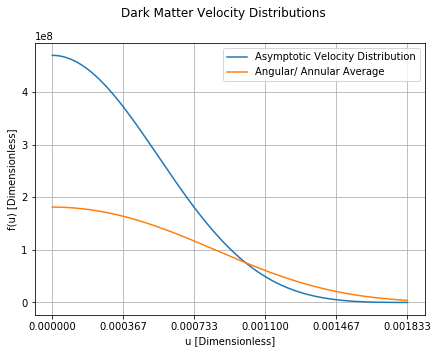

In [11]:
velRange = np.linspace(0, V_gal, 200)

#######################
# Populate Vectors
#######################
ModDMVect1 = []
DMVect1 = []
for vel in velRange:
    DMVect1.append(DMVelDist(vel))
    ModDMVect1.append(ModDMVelDist(vel))
    
#######################
# Plot
#######################
plt1_xlabel = np.linspace(0, V_gal, 6)

fig1 = plt.figure(figsize = (7,5))
ax1 = fig1.add_subplot(111)
ax1.set_xticks(plt1_xlabel)
line1, = plt.plot(velRange,DMVect1)
line2, = plt.plot(velRange,ModDMVect1)

plt.xlabel(r'u [Dimensionless]', fontsize = 13)
plt.ylabel(r'f(u) [Dimensionless]', fontsize = 13)
plt.grid()
plt.legend([line1, line2,],['Asymptotic Velocity Distribution', 'Angular/ Annular Average'], loc='upper right')
plt.suptitle('Dark Matter Velocity Distributions', fontsize = 16)
# plt.title('Full Integration Region')


print ('Complete')

The following cell saves the velocity distribution plot to the "Photon/ApproximationPlots" folder.

In [ ]:
# Save the plot if you want
filename1 = input('Plot1 Filename: ')

fig1.savefig(photonApproxPath(filename1), dpi = 700)

print ('Complete')

#### Modified Distribution Interpolation

We interpolate the modified velocity distribution and plot a few data points to check the interpolation.

In [ ]:
DMVect2 = []

for vel in velRange:
    DMVect2.append(ModDMVelInterp(vel))

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
points1, = plt.plot(velRange, ModDMVect1,'.')
line1, = plt.plot(velRange,DMVect2)

plt.xlabel(r'Incident Velocity')
plt.ylabel(r"f'(u)")
plt.suptitle('Modified DM Velocity Interpolation Check')
plt.legend([points1,line1],['List Values','Interpolation'])
plt.axis([0,2.8e-4,1.6e8,1.9e8])
plt.grid()

print ('Complete')

### Kinematics

The dimensionfull recoil energy limits are:
\begin{equation} 
E_{Min} = \frac{1}{2} m_X u^2 \ \ \ \ \ \ \ \ E_{Max} = 2 \frac{\mu^2}{m_N} (u^2 + v_{\oplus}^2)
\end{equation}

The dimensionless recoil energy limits used in the $\kappa_0$ calculation are:
\begin{equation}
\xi_{Min} = \frac{1}{2}u^2 \ \ \ \ \ \ \ \ \xi_{max} = 2\frac{\mu_N^2}{m_Nm_X}(u^2+ v_{\oplus}^2)
\end{equation}

We expect $\xi_{Min, Max} = \frac{E_{Min, Max}}{m_X}$

In [ ]:
test1 = eMin(E_RTest, m_XTest)
test2 = eMax(elementTest, m_XTest, indexTest, E_RTest)
test3 = xiMin(E_RTest, m_XTest)
test4 = xiMax(elementTest, m_XTest, indexTest, E_RTest)

print ('Emin: {0}'.format(test1))
print ('Emax: {0}'.format(test2))
print ('Ximin: {0}'.format(test3))
print ('Ximax: {0}'.format(test4))

print ('Complete')

### Capture Integral

In the following cell, we calculate the velocity and recoil energy integrals:

\begin{equation}
\text{IntDuDEr} = \int_{0}^{uInt} du\space u \, f(u) \int_{E_{min}}^{E_{Max}} dE_R \space \frac{d \sigma_N}{dE_R} 
\end{equation}

with dimension: $[ \text{IntDuDEr}] = \frac{1}{GeV^3}$

where 
\begin{equation}
u_{int}^2 = \frac{2\mu_N^2}{m_N} \frac{1}{ \left( \frac{1}{2m_X} - \frac{2\mu_N^2}{m_N} \right)  } v_{\oplus}^2 
\end{equation}

See Appendix A for a discussion of calculating this integral.

The $\kappa_0$ calculation uses:
\begin{equation}
\text{IntDuDErKappa0} = \int_{0}^{uInt} du\space u \, f(u) \int_{\xi_{min}}^{\xi_{Max}} d\xi_{R}
\end{equation}

##### Factors Removed (IntDuDEr):  $(4\pi)(8\pi \epsilon^2 \alpha_X \alpha m_N Z_N^2)$
##### Factors Removed (IntDuDErApprox): $(4\pi)(8\pi \alpha_X \alpha \frac{\epsilon^2}{m_A^4} m_N Z_N^2)$

In [7]:
test1 = photonIntDuDEr(elementTest, m_XTest, m_ATest, indexTest)
test2 = photonIntDuDErKappa0(elementTest, m_XTest, indexTest)

print ('Calculation: {0}'.format(test1))
print ('Kappa0     : {0}'.format(test2))

print ('Complete')

Calculation: 5.920184210376575e-09
Kappa0     : 5.927700272048579e-12
Complete


### Sum Over Radii

In the following cell, we calculate the "integral" over the radius of earth:

\begin{equation}
\int^{R_{earth}}_{0} dr\space 4\pi r^2 n_N(r) \int_{0}^{uInt} du\space 4\pi u f(u) \int_{E_{min}}^{E_{Max}} dE_R \space \frac{d \sigma_N}{dE_R} 
\end{equation}

where we rename the velocity and recoil energy integrals to their respective python function $\text{IntDuDEr}$:

\begin{equation}
\int^{R_{earth}}_{0} dr\space 4\pi r^2 n_N(r) \space \text{IntDuDEr}
\end{equation}

with dimension $ \frac{1}{\text{GeV}^3}$

However, instead of calculating this as an integral as stated, we discretize the integral and use the thin-shell approximation:

\begin{equation}
\frac{4}{3}\pi (r +\Delta r)^3 - \frac{4}{3}\pi r^3 = 4 \pi r^2 \Delta r
\end{equation}

which yields the discrete summation:

\begin{equation}
\text{SumOverR} = \sum_{i} r_i^2 n_N(r) \Delta r_i \ \text{IntDuDEr}
\end{equation}

where the variables $r_i$, $n_N(r)$, and $\Delta r_i$ are given by:

\begin{equation} 
r_i = \text{radiusList[i]} 
\ \ \ \ \ \ \ \ 
n_N(r) = \text{numDensityList(element)[i]}
\ \ \ \ \ \ \ \  
\Delta r_i = \text{deltaRList[i]}
\end{equation}

It is important to note, $i$ is a pure summation index and all physical quantites depending on i are taken from the respective lists.
 
In the Kappa0 calculation we use:
\begin{equation}
\text{SumOverRKappa0} = \sum_i r_i^2 n_N(r) \Delta r_i \ \text{IntDuDErKappa0}
\end{equation}

##### Removed Factors: $(4\pi)(4\pi)(8\pi \alpha_X \alpha \epsilon^2 m_N Z_N^2)$
##### Removed Factors (Kappa0): $(4\pi)(4\pi)(8\pi \alpha_X \alpha \frac{\epsilon^2}{m_A^4} m_N Z_N^2)$

In [4]:
test1 = photonSumOverR(elementTest, m_XTest, m_ATest)
test2 = photonSumOverRKappa0(elementTest, m_XTest)

print ('Complete')

Complete


In [5]:
print ('Calculation: {0}'.format(test1))
print ('Kappa0     : {0}'.format(test2))

print ('Complete')

Calculation: 7.647109309917228e+39
Kappa0     : 7.655899228016357e+36
Complete


### Single-Element Capture Rate: $C^N_{Cap}$

The final step is to tack on all of the removed factors and calculate the capture rate for a single element:

\begin{align} 
\text{singleElementCap} &= \left[(4\pi)(4\pi)(8\pi \epsilon^2 \alpha_X \alpha m_N Z_N^2)\right] n_X \text{sumOverR} \\ \nonumber
&= \left[2(4\pi)^3(\epsilon^2 \alpha_X \alpha m_N Z_N^2)\right] n_X \text{sumOverR}
\end{align}

where $[n_X] = \frac{1}{cm^3}$ and $[sumOverR] = \frac{1}{GeV^2}$, so $[fullCap] = \frac{1}{cm^3 GeV^2}$

We manually multiply by the following conversions:
$$ \frac{cm \cdot GeV}{5.06\times10^{13}} =  1 
\ \ \ \ 
\text{and} 
\ \ \ \ 
\frac{1.52\times10^{24}}{GeV\cdot s} = 1$$

In the Kappa0 calculation:
\begin{equation}
\text{singleElementCapKappa0} = m_X^{-2} 8\pi \alpha Z_N^2 \frac{m_N}{m_X} m_X^4 (4\pi)^2 n_X \text{SumOverRKappa0}
\end{equation}

In the following cell, we test the following functions:


1). $\text{singleElementCap}$

2). $\text{singleElementCapKappa0}$

3). $\text{singleElementCapKappa0}\frac{\varepsilon^2}{m_A^4}$

and we expect that $\text{singleElementCap} =  \text{singleElementCapKappa0}\frac{\varepsilon^2}{m_A^4}$

In [8]:
test1 = photonSingleElementCap(elementTest, m_XTest, m_ATest, epsilonTest, alphaTest, alpha_XTest)
test2 = photonSingleElementCapKappa0(elementTest, m_XTest, alphaTest)
test3 = test2 * alphaTherm(m_XTest,m_ATest) * epsilonTest**2 / m_ATest**4

print ('Complete')

Complete


In [9]:
print ('Single Element Capture         : {0}'.format(test1))
print ('Single Element Capture(Kappa0) : {0}'.format(test3))
print ('Single Element Kappa0 only     : {0}'.format(test2))

print ('Difference: {0}'.format(difference(test1,test3)))
print ('Complete')

Single Element Capture         : 96935116.02002965
Single Element Capture(Kappa0) : 95800437.41414623
Single Element Kappa0 only     : 2.772758212394951e+25
Difference: -0.011705547509211848
Complete


This cell tests:


1). singleElementCap

2). singleElementCapKapa0

for $m_X = 1000$ GeV over the four corners of parameter space and the middle $(\varepsilon, m_A) = (10^{-7.5}, 5.0)$

We expect the $\kappa_0$ calculation to hold for large $m_A$ and to start to diverge for small $m_A$.

In [10]:
alpha = 1./137
alpha_X = 0.035

mx1000 = 1000.

mam2 = 0.01
ma5 = 5.
ma1 = 10.

epsilonm10 = 10**-10
epsilonm75 = 10**-7.5
epsilonm5 = 10**-5

a1 = photonSingleElementCap      ('Fe56', mx1000, mam2, epsilonm10, alpha, alpha_X)
a2 = photonSingleElementCapKappa0('Fe56', mx1000,                   alpha) * alpha_X * ((epsilonm10)**2/(mam2)**4)

b1 = photonSingleElementCap      ('Fe56', mx1000, mam2, epsilonm5 , alpha, alpha_X)
b2 = photonSingleElementCapKappa0('Fe56', mx1000,                   alpha) * alpha_X * ((epsilonm5)**2/(mam2)**4)

c1 = photonSingleElementCap      ('Fe56', mx1000, ma1 , epsilonm5 , alpha, alpha_X)
c2 = photonSingleElementCapKappa0('Fe56', mx1000,                   alpha) * alpha_X * ((epsilonm5)**2/(ma1)**4)

d1 = photonSingleElementCap      ('Fe56', mx1000, ma1 , epsilonm10, alpha, alpha_X)
d2 = photonSingleElementCapKappa0('Fe56', mx1000,                   alpha) * alpha_X * ((epsilonm10)**2/(ma1)**4)

e1 = photonSingleElementCap      ('Fe56', mx1000, ma5 , epsilonm75, alpha, alpha_X)
e2 = photonSingleElementCapKappa0('Fe56', mx1000,                   alpha) * alpha_X * ((epsilonm75)**2/(ma5)**4)

print ('Complete')

Complete


In [11]:
print ('m_A = {0}, Epsilon = {1} :\n    Full:   {2} \n    Kappa0: {3}'.format(mam2,epsilonm10,a1,a2))
print ('---------------')
print ('m_A = {0}, Epsilon = {1} :\n    Full:   {2} \n    Kappa0: {3}'.format(mam2,epsilonm5,b1,b2))
print ('---------------')
print ('m_A = {0}, Epsilon = {1} :\n    Full:   {2} \n    Kappa0: {3}'.format(ma1,epsilonm5,c1,c2))
print ('---------------')
print ('m_A = {0}, Epsilon = {1} :\n    Full:   {2} \n    Kappa0: {3}'.format(ma1,epsilonm10,d1,d2))
print ('---------------')
print ('m_A = {0}, Epsilon = {1} :\n    Full:   {2} \n    Kappa0: {3}'.format(ma5,epsilonm75,e1,e2))

print ('Complete')

m_A = 0.01, Epsilon = 1e-10 :
    Full:   722582089935.9792 
    Kappa0: 970465374338.2329
---------------
m_A = 0.01, Epsilon = 1e-05 :
    Full:   7.225820899359792e+21 
    Kappa0: 9.704653743382331e+21
---------------
m_A = 10.0, Epsilon = 1e-05 :
    Full:   9693824675.572641 
    Kappa0: 9704653743.382332
---------------
m_A = 10.0, Epsilon = 1e-10 :
    Full:   0.9693824675572641 
    Kappa0: 0.9704653743382331
---------------
m_A = 5.0, Epsilon = 3.162277660168379e-08 :
    Full:   1551010.4301186088 
    Kappa0: 1552744.5989411725
Complete


We can see that for small $m_A$, Kappa0 diverges from the full calculation, since the small recoil energy approximation requited that $2m_NE_R \ll m_A^2$ but for low $m_A$, the approximation begins to break down.

In this cell, we reproduce the capture rates for the various elements in Table 1 of arXiv:1509.07525v2.

To match input values, we set:

$m_X = 1000$ GeV

$m_A = 1$ GeV

$\varepsilon = 10^{-8}$

$\alpha = 1/137$

$\alpha_X = 0.035$


In [12]:
# These are the values from Table 1 of ArXiV: 1509.07525v2.
CCapPaper = {# CCapFlip[(n), alphaX = 0.035, epsilon = 10e-8, m_X = m_XTest, m_A = 1]
    'O16' : 4.03e5,
    'Si28': 2.24e6,
    'Mg24': 1.05e6,
    'Fe56': 9.43e7,
    'Ca40': 9.06e5,
    'P31' : 2.04e4,
    'S32' : 2.41e5,
    'Ni58': 7.10e6,
    'Al27': 1.62e5,
    'Cr52': 8.98e5 
}

CCapAdam0 = {
    'O16' : 0,
    'Si28': 0,
    'Mg24': 0,
    'Fe56': 0,
    'Ca40': 0,
    'P31' : 0,
    'S32' : 0,
    'Al27': 0,
    'Cr52': 0,
    'Ni58': 0
}

CCapAdam1 = {
    'O16' : 0,
    'Si28': 0,
    'Mg24': 0,
    'Fe56': 0,
    'Ca40': 0,
    'P31' : 0,
    'S32' : 0,
    'Al27': 0,
    'Cr52': 0,
    'Ni58': 0
}

CCapAdam2 = {
    'O16' : 0,
    'Si28': 0,
    'Mg24': 0,
    'Fe56': 0,
    'Ca40': 0,
    'P31' : 0,
    'S32' : 0,
    'Al27': 0,
    'Cr52': 0,
    'Ni58': 0
}

m_X = 1000.
m_A = 1.
epsilon = 10**-8
alpha = 1./137
alpha_X = 0.035

for element in elementList:
    CCapAdam0[element] = photonSingleElementCap(element, m_X, m_A, epsilon, alpha, alpha_X)
    CCapAdam1[element] = photonSingleElementCapKappa0(element, m_X, alpha) * alpha_X * (epsilon)**2 / (m_A)**4
    
print ('Complete')

Complete


In [13]:
print ('Full Calculation')
for element in elementList:
    print ('Capture rate of {0}: {1}'.format(element,CCapAdam0[element]))

print ()
print ('--------------')
print ()
    
print ('Kappa0 Calculation')
for element in elementList:
    print ('Capture rate of {0}: {1}'.format(element,CCapAdam1[element]))

print ()
print ('--------------')
print ()

print ('Error on the full calculation')
for element in elementList:
    print ('Error on {0}: {1}'.format(element,difference(CCapPaper[element],CCapAdam0[element])))

print ()
print ('Complete')

Full Calculation
Capture rate of O16: 428207.1168550287
Capture rate of Mg24: 1123861.4311637017
Capture rate of Al27: 172097.56693898616
Capture rate of Si28: 2369728.722003662
Capture rate of P31: 20916.12819128281
Capture rate of S32: 247841.95005328607
Capture rate of Ca40: 963709.850343634
Capture rate of Cr52: 929462.8250178562
Capture rate of Fe56: 96935116.02002965
Capture rate of Ni58: 7291975.362009343

--------------

Kappa0 Calculation
Capture rate of O16: 428221.1745941974
Capture rate of Mg24: 1123968.6783835755
Capture rate of Al27: 172119.97629451423
Capture rate of Si28: 2370087.8098132988
Capture rate of P31: 20920.74928305337
Capture rate of S32: 247907.443690214
Capture rate of Ca40: 964064.8809231704
Capture rate of Cr52: 930303.0569725557
Capture rate of Fe56: 97046537.4338233
Capture rate of Ni58: 7301694.549023448

--------------

Error on the full calculation
Error on O16: 0.06254867705962464
Error on Mg24: 0.07034422015590637
Error on Al27: 0.06233066011719850

### Total Capture Rate: $C_{Cap}$


Finally, we arrive at the full capture rate. 

\begin{equation}
C_{\text{cap} } = \sum_N C_{\text{N} }^N
\end{equation}

CCap gives the total capture rate for dark matter mass $m_X$ in GeV, mediator mass $m_A$ in GeV, kinetic mixing parameter $\epsilon$, and $\alpha_X$ as set by the thermal relic.

We test the following functions:

1).photonCCap

2).photonCCapQuick


for the following parameters: 
\begin{equation}
m_X = 1000 \ \text{GeV}
\ \ \ \  
m_A = 1.0 \ \text{GeV}
\ \ \ \
\varepsilon = 10^{-8}
\ \ \ \
\alpha = \frac{1}{137}
\ \ \ \
\alpha_X = 0.035
\end{equation}


In [14]:
# m_X = 1000.
# m_A = 1.
# epsilon = 10**-8
# alpha = 1./137
# alpha_X = 0.035

PaperSum = 0
for element in CCapPaper:
    PaperSum += CCapPaper[element]
    
test1 = photonCCap(m_XTest, m_ATest, epsilonTest, alphaTest, alpha_XTest)
testkappa0 = photonKappa_0(m_XTest, alphaTest)
test2 = photonCCapQuick(m_XTest, m_ATest, epsilonTest, alpha_XTest, testkappa0)

print ('Complete')

Complete


In [15]:
print ('Full Calculation  : {0}'.format(test1))
print ('Kappa0 Calculation: {0}'.format(test2))
print ('Paper Capture Rate: {0}'.format(PaperSum))

print ('Difference: {0}'.format(difference(PaperSum, test2)))
print ('Complete')

Full Calculation  : 110482916.97260644
Kappa0 Calculation: 110605825.75280133
Paper Capture Rate: 107320400.0
Difference: 0.030613245504129027
Complete


### Kappa_0 Check

We define CCapQuick as the full capture calculation using the small recoil energy approximation $\kappa_0$.

\begin{equation}
\text{photonCcapQuick} = \frac{\varepsilon^2}{m_A^4} \alpha_X \kappa_0
\end{equation}


We expect that by construction, photonCCapQuick = phtonKappa_0 $\times \alpha_X \times \frac{\varepsilon^2}{m_{A'}^4}$

In [16]:
print (testkappa0*alpha_XTest*epsilonTest**2/m_ATest**4)
print (test2)

110605825.753
110605825.753
